In [1]:
import os
import time
from datetime import datetime
from pathlib import Path

import akshare as ak
import matplotlib.pyplot as plt
import pandas as pd
import snoop
from pylab import legend
from snoop import pp

%matplotlib inline

In [2]:
fund_code = '510300'
init_cash = cash = 100000
s_buy_point, buy_point, sell_point, norm_point, s_sell_point = 0.05, 0.15, 0.5, 0.85, 0.95
s_buy_position, buy_position, sell_position, s_sell_position = 0.95, 0.85, 0.5, 0.05
fund_cache_file = f'../test-cached/open_fund/{fund_code}.csv'
op_df = pd.DataFrame()

In [3]:
# @snoop
def is_gt_24hours(early_dt, later_dt):
    return (later_dt - early_dt).days >= 1


def cache_fund_to_csv(fund_code, filename):
    open_fund_df = ak.fund_open_fund_info_em(fund=fund_code, indicator="单位净值走势")
    open_fund_df.to_csv(filename, index_label='index')


def recent_10_years(df):
    r_10_df = df.tail(10 * 12)
    # result_df = r_11_df.iloc[1:] #去除第一行异常数据
    return r_10_df.reset_index()


def get_cached_fund_df(fund_code, cached_file):
    if not Path(cached_file).exists():
        cache_fund_to_csv(fund_code, cached_file)

    cached_file_dt = datetime.fromtimestamp(os.stat(cached_file).st_mtime)

    if is_gt_24hours(cached_file_dt, datetime.now()):
        cache_fund_to_csv(fund_code, cached_file)

    return pd.read_csv(cached_file, parse_dates=['净值日期'], index_col=['净值日期'])


def pre_process(df):
    df.drop(columns=['index', '日增长率'], inplace=True)
    return df.resample("MS").first()


def ten_years_pct_change(df):
    recent_one_year_s = df['单位净值'].pct_change(periods=12)

    result_df = df.copy()
    result_df['一年滚动增长'] = recent_one_year_s

    # 处理前12行没有数据的问题
    result_df.loc[0, '一年滚动增长'] = 0
    for i in range(12):
        result_df.loc[i + 1, '一年滚动增长'] = (
            df.loc[i + 1, '单位净值'] / df.loc[0, '单位净值']
        ) - 1
    return result_df


def recacl_account(df):
    total_value = df['份额变化'] * df['单位净值']


def op_to_position(row, total_value, exp_position=0.7):
    global cash
    curr_position = 1 - cash / total_value
    print(f"当前仓位: {curr_position}, 期望仓位: {exp_position}")
    exp_cash = total_value * (1 - exp_position)
    cash_to_op = cash - exp_cash
    if abs(cash_to_op/total_value) <= 0.005: # 操作资金不足总资金量的0.5%
        print(f"不足总资金量的0.5%，无操作\n")
        return row
    
    op_row = row.copy()
    op_row['交易变化'] = cash_to_op
    op_row['份额变化'] = op_row['交易变化'] / op_row['单位净值']
    cash = exp_cash
    op_row['现金余额'] = cash
    print(f"交易金额: {op_row['交易变化']}, 份额变化: {op_row['份额变化']}, 现金余额: {cash}\n")
    return op_row

In [4]:
fund_df = get_cached_fund_df(fund_code, fund_cache_file)

by_month_df = pre_process(fund_df)

recent_10_years_df = recent_10_years(by_month_df)
recent_10_years_df = ten_years_pct_change(recent_10_years_df)
# recent_10_years_df

## 交易初始化

In [5]:
recent_10_years_df['交易变化'] = 0
recent_10_years_df['份额变化'] = 0
recent_10_years_df['现金余额'] = 0
recent_10_years_df.loc[0] = op_to_position(recent_10_years_df.loc[0], cash, 1)

当前仓位: 0.0, 期望仓位: 1
交易金额: 100000, 份额变化: 44150.11037527594, 现金余额: 0



In [6]:
quantiles = recent_10_years_df['一年滚动增长'].quantile(
    [s_buy_point, buy_point, norm_point, sell_point, s_sell_point]
)
quantiles

0.05   -0.216751
0.15   -0.148197
0.85    0.288000
0.50    0.072558
0.95    0.555755
Name: 一年滚动增长, dtype: float64

In [7]:
buy_point_df = recent_10_years_df.loc[
    recent_10_years_df['一年滚动增长'] <= quantiles[buy_point]
]
print(f'买入机会: {len(buy_point_df)} 次')
sell_point_df = recent_10_years_df.loc[
    recent_10_years_df['一年滚动增长'] >= quantiles[sell_point]
]
print(f'卖出机会: {len(sell_point_df)} 次')

# buy_point_df

买入机会: 18 次
卖出机会: 60 次


In [8]:
for i, row in recent_10_years_df.iterrows():
    curr_value = recent_10_years_df.iloc[:i]['份额变化'].sum() * row['单位净值'] + cash
    # recent_10_years_df.loc[i, '资产总额'] = curr_value
    # 超级买入机会
    if row['一年滚动增长'] <= quantiles[s_buy_point]:
        print(
            f"发现超级买点, {row['净值日期'].strftime('%Y-%m-%d')}, 总资产: {curr_value}, {row['一年滚动增长']}, 当前净值: {row['单位净值']}, 现金余额: {cash}"
        )

        recent_10_years_df.iloc[i] = op_to_position(row, curr_value, s_buy_position)
    # 普通买入机会
    if quantiles[s_buy_point] <= row['一年滚动增长'] <= quantiles[buy_point]:
        print(
            f"发现普通买点，{row['净值日期'].strftime('%Y-%m-%d')}, 总资产: {curr_value}, {row['一年滚动增长']}, 当前净值: {row['单位净值']}, 现金余额: {cash}"
        )

        recent_10_years_df.iloc[i] = op_to_position(row, curr_value, buy_position)

    # 普通卖出机会
    if quantiles[sell_point] <= row['一年滚动增长'] <= quantiles[s_sell_point]:
        print(
            f"发现普通卖点，{row['净值日期'].strftime('%Y-%m-%d')}, 总资产: {round(curr_value)}, {row['一年滚动增长']}, 当前净值: {row['单位净值']}, 现金余额: {cash}"
        )

        recent_10_years_df.iloc[i] = op_to_position(row, curr_value, sell_position)
    # 超级卖出机会
    if quantiles[s_sell_point] <= row['一年滚动增长']:
        print(
            f"发现超级卖点，{row['净值日期'].strftime('%Y-%m-%d')}, 总资产: {curr_value}, {row['一年滚动增长']}, 当前净值: {row['单位净值']}, 现金余额: {cash}"
        )

        recent_10_years_df.iloc[i] = op_to_position(row, curr_value, s_sell_position)

recent_10_years_df.to_csv(
    f'../test-cached/open_fund/{fund_code}_滚动收益.csv', index_label='index'
)

发现普通卖点，2013-01-01, 总资产: 111567, 0.11567328918322306, 当前净值: 2.527, 现金余额: 0
当前仓位: 1.0, 期望仓位: 0.5
交易金额: -55783.66445916115, 份额变化: -22075.05518763797, 现金余额: 55783.66445916115

发现普通卖点，2013-02-01, 总资产: 116333, 0.2109933774834436, 当前净值: 2.7429, 现金余额: 55783.66445916115
当前仓位: 0.5204842596633712, 期望仓位: 0.5
交易金额: -2383.002207505524, 份额变化: -868.7893133200349, 现金余额: 58166.66666666667

发现普通卖点，2013-03-01, 总资产: 114722, 0.17743929359823385, 当前净值: 2.6669, 现金余额: 58166.66666666667
当前仓位: 0.4929757107471625, 期望仓位: 0.5
交易金额: 805.8381032240868, 份额变化: 302.16284945970483, 现金余额: 57360.828563442585

发现普通卖点，2013-04-01, 总资产: 110973, 0.10048565121412789, 当前净值: 2.4926, 现金余额: 57360.828563442585
当前仓位: 0.4831088283748426, 期望仓位: 0.5
交易金额: 1874.459563277218, 份额变化: 752.0097742426454, 现金余额: 55486.36900016537

发现普通卖点，2013-05-01, 总资产: 110029, 0.08176600441501103, 当前净值: 2.4502, 现金余额: 55486.36900016537
当前仓位: 0.49571093307437086, 期望仓位: 0.5
不足总资金量的0.5%，无操作

发现普通卖点，2013-06-01, 总资产: 113602, 0.15262693156732876, 当前净值: 2.6107, 现金余额: 

## 总资产

In [9]:
account = {}
account['份额'] = round(recent_10_years_df['份额变化'].sum(), 4)
account['资产价值'] = round(fund_df.tail(1)['单位净值'][0] * account['份额'], 2)
account['现金余额'] = round(cash, 2)
account['总资产'] = round(account['资产价值'] + account['现金余额'], 2)
account['年化收益'] = '{:.2%}'.format(pow(account['总资产'] / init_cash, 1 / 10) - 1, 4)
account

{'份额': 38962.0521,
 '资产价值': 162245.78,
 '现金余额': 29196.79,
 '总资产': 191442.57,
 '年化收益': '6.71%'}

## 对比满仓不做操作

In [10]:
no_op_account = {}
no_op_account['份额'] = round(init_cash / recent_10_years_df.head(1)['单位净值'][0], 4)
no_op_account['资产价值'] = round(fund_df.tail(1)['单位净值'][0] * no_op_account['份额'], 2)
no_op_account['现金余额'] = 0
no_op_account['总资产'] = round(no_op_account['资产价值'] + no_op_account['现金余额'], 2)
no_op_account['年化收益'] = '{:.2%}'.format(
    pow(no_op_account['总资产'] / init_cash, 1 / 10) - 1, 4
)
no_op_account

{'份额': 44150.1104,
 '资产价值': 183849.89,
 '现金余额': 0,
 '总资产': 183849.89,
 '年化收益': '6.28%'}

## 可视化

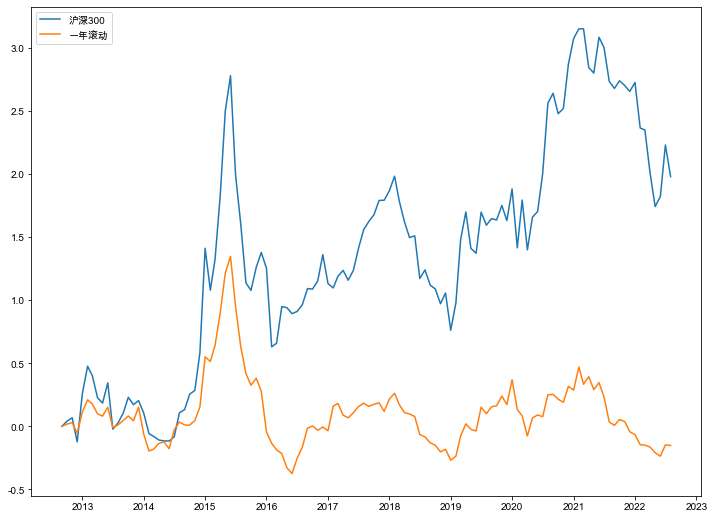

In [11]:
plt.rcParams["font.family"] = 'Arial Unicode MS'  # 设置字体，正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 设置字体，正常显示中文
plt.figure(figsize=(12, 9))

plt.plot(
    recent_10_years_df['净值日期'],
    recent_10_years_df['单位净值'] - recent_10_years_df['单位净值'].head(1)[0],
    label='沪深300',
)
plt.plot(recent_10_years_df['净值日期'], recent_10_years_df['一年滚动增长'], label='一年滚动')

plt.axis('tight')
legend(loc='upper left')